# Self-RAG

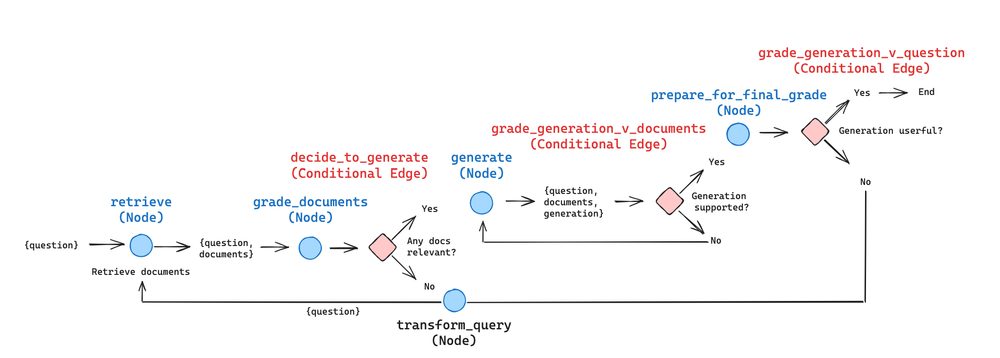

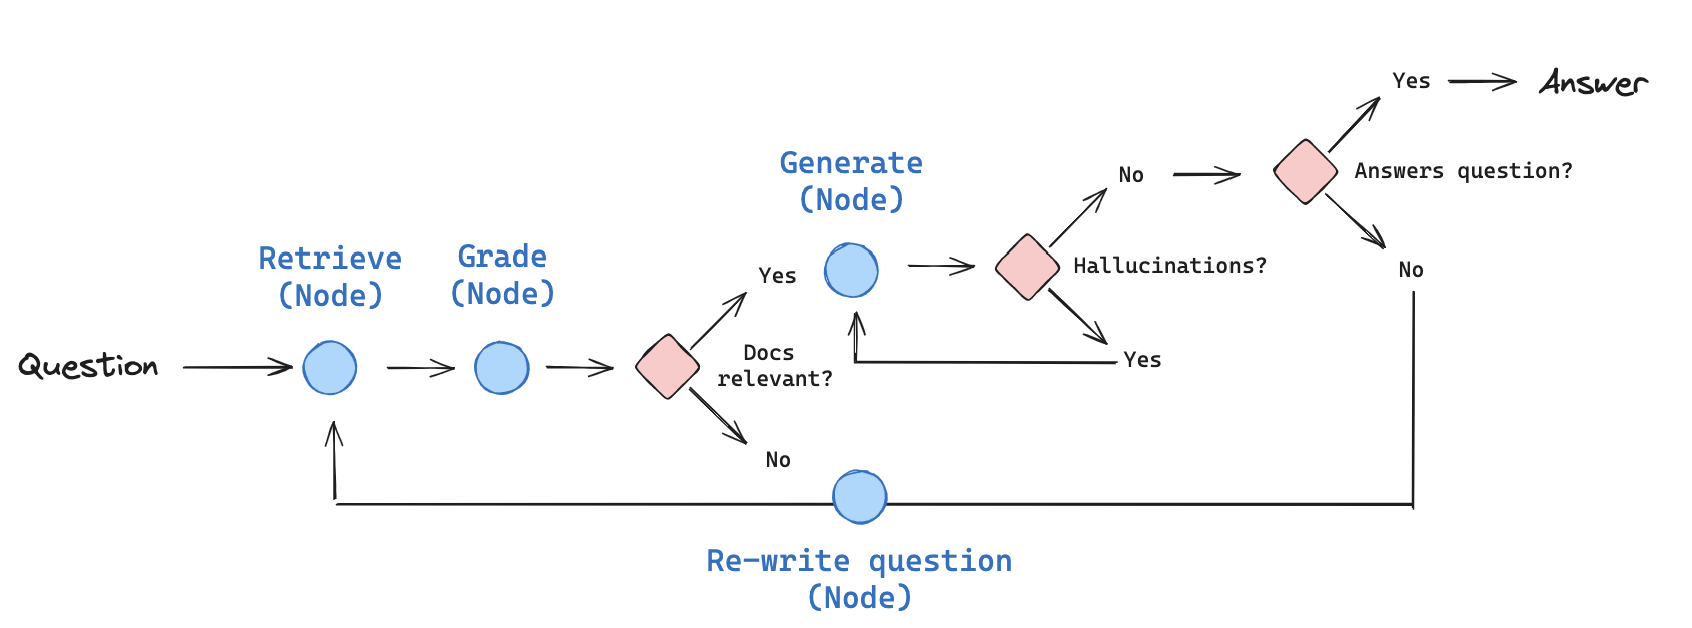

## Dependencies

In [41]:
! pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-groq datasets ragas

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/89.0 kB ? eta -:--:--
   ------------- -------------------------- 30.7/89.0 kB 660.6 kB/s eta 0:00:01
   ------------------------------------ --- 81.9/89.0 kB 919.0 kB/s eta 0:00:01
   ---------------------------------------- 89.0/89.0 kB 722.4 kB/s eta 0:00:00
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.1.4
    Uninstalling langgraph-0.1.4:
      Successfully uninstalled langgraph-0.1.4


## LLM

In [42]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")

## Tracing

In [43]:
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")

In [44]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] = "Self-RAG"

## Retriever

In [45]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

## Generation

In [104]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
    api_key=groq_api_key)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain1 = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    |StrOutputParser()
    
)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Agent memory refers to a long-term memory module, which is an external database that records a comprehensive list of agents' experience in natural language. This memory module enables agents to behave conditioned on past experience and interact with other agents.


## RAGAS

In [105]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_utilization,
    context_relevancy
)

questions = ["what is agent memory?",
                "what is long term memory?"]

answers=[]
contexts=[]

for query in questions:
    answers.append(rag_chain1.invoke(query))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(query)])

In [106]:
answers

["Agent memory refers to a long-term memory module, which is an external database that records a comprehensive list of agents' experiences in natural language. This allows agents to behave conditioned on past experience and interact with other agents.",
 'Long-term memory can store information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity. It has two subtypes: explicit/declarative memory, which stores facts and events, and implicit/procedural memory, which involves skills and routines performed automatically.']

In [107]:
contexts

[['They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to execute the procedure. 7 out of 11 were rejected and among these 7 rejected cases, 5 happened after a Web search while 2 were rejected based on prompt only.\nGenerative Agents Simulation#\nGenerative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.\nThe design of generative agents combines LLM with memory, planning and reflection mechanisms to enable agents to behave conditioned on past experience, as well as to interact with other agen

## Data

In [108]:
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,}

In [109]:
data

{'question': ['what is agent memory?', 'what is long term memory?'],
 'answer': ["Agent memory refers to a long-term memory module, which is an external database that records a comprehensive list of agents' experiences in natural language. This allows agents to behave conditioned on past experience and interact with other agents.",
  'Long-term memory can store information for a remarkably long time, ranging from a few days to decades, with an essentially unlimited storage capacity. It has two subtypes: explicit/declarative memory, which stores facts and events, and implicit/procedural memory, which involves skills and routines performed automatically.'],
 'contexts': [['They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the agent attempted to consult documentation to exe

## Evaluation

In [110]:
dataset = Dataset.from_dict(data)
result = evaluate(
    dataset,
    metrics=[faithfulness, answer_relevancy, context_relevancy, context_utilization]
)

result

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead
Using 'context_precision' without ground truth will be soon depreciated. Use 'context_utilization' instead


{'faithfulness': 0.8750, 'answer_relevancy': 0.9154, 'context_relevancy': 0.0716, 'context_utilization': 1.0000}

## Retrieval Grader

In [73]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )
    num_score: float = Field(description="Score from 0 to 1")


# LLM with function call
#llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
    api_key=groq_api_key)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
ret_score = retrieval_grader.invoke({"question": question, "document": doc_txt})

ret_output = {
    "binary_score": ret_score.binary_score,
    "num_score": result['context_relevancy']
}

ret_output

{'binary_score': 'yes', 'num_score': 0.07158119658119658}

## Hallucination Grader

In [69]:
# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
    num_score: float = Field(description="Score from 0 to 1")


# LLM with function call
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
    api_key=groq_api_key)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.""" 
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# Combine the prompt template with the structured LLM grader
hallucination_grader = hallucination_prompt | structured_llm_grader

# Invoke the grader and capture the result
hal_score = hallucination_grader.invoke({"documents": docs, "generation": generation})

# Manually assign the num_score from result['faithfulness']
hal_output = {
    "binary_score": hal_score.binary_score,
    "num_score": result['faithfulness']
}

hal_output


{'binary_score': 'yes', 'num_score': 0.875}

## Answer Grader

In [63]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )
    num_score: float = Field(description="Score from 0 to 1")


# LLM with function call
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
    api_key=groq_api_key)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
ans_score =answer_grader.invoke({"question": question, "generation": generation})

ans_output = {
    "binary_score": ans_score.binary_score,
    "num_score": result['answer_relevancy']
}

In [64]:
ans_output

{'binary_score': 'yes', 'num_score': 0.9206513195069783}

## Question Re-writer

In [25]:
# LLM
llm = ChatGroq(
    temperature=0,
    model="llama3-70b-8192",
    api_key=groq_api_key)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'After analyzing the initial question, I\'ve rephrased it to better capture the underlying semantic intent and optimize it for vector store retrieval:\n\n**Improved question:** "What is the concept of memory in artificial intelligence agents?"\n\nThis rephrased question aims to clarify the intent behind the original query, which seems to be seeking information about the memory component in artificial intelligence agents. The revised question is more specific, concise, and likely to retrieve relevant results from a vector store.'

## Graph state

In [26]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Nodes

In [111]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        num_score = ret_output["num_score"]
        if grade == "yes" or num_score > 0.5:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score
    num_score = hal_output['num_score']
    # Check hallucination
    if grade == "yes" or num_score > 0.5:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        num_score = ans_output['num_score']
        if grade == "yes" or num_score > 0.5:
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

In [112]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

In [113]:
from pprint import pprint

# Run
inputs = {"question": "Explain how the different types of agent memory work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Sensory memory is the earliest stage of memory, providing the ability to '
 'retain impressions of sensory information for up to a few seconds. '
 'Short-term memory allows the model to learn through in-context learning, '
 'such as prompt engineering. Long-term memory provides the agent with the '
 'capability to retain and recall information over extended periods, often by '
 'leveraging an external vector store and fast retrieval.')


In [114]:
inputs = {"question": "Explain how chain of thought prompting works?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Chain of thought prompting involves providing a model with a few '
 'demonstrations, each containing manually written or model-generated '
 'high-quality reasoning chains, to steer its behavior for desired outcomes. '
 'This method is also known as few-shot CoT. The goal is to communicate with '
 'the language model to achieve desired outcomes without updating the model '
 'weights.')
